In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import chirp, tukey, fftconvolve, correlate
import matplotlib.pyplot as plt
import os

In [2]:
def generate_improved_sine_sweep_v4(fs=48000, duration=45, sweep_duration=30, f0=20, f1=20000, method='logarithmic', 
                                    silence_start=0.5, taper=0.1, amplitude=0.9):
    t = np.linspace(0, sweep_duration, int(fs * sweep_duration), endpoint=False)
    sweep = amplitude * chirp(t, f0=f0, f1=f1, t1=sweep_duration, method=method)
    
    window = tukey(len(sweep), alpha=taper)
    sweep *= window
    
    if method == 'logarithmic':
        omega1, omega2 = 2 * np.pi * f0, 2 * np.pi * f1
        envelope = np.exp(-t * omega1 * (np.log(omega2/omega1) / sweep_duration))
        inverse_filter = sweep[::-1] * envelope / (sweep * sweep[::-1]).mean()
    else:
        inverse_filter = sweep[::-1] / (sweep * sweep[::-1]).mean()
    
    silence_start_samples = int(silence_start * fs)
    silence_end_samples = int((duration - sweep_duration - silence_start) * fs)
    sweep = np.pad(sweep, (silence_start_samples, silence_end_samples), 'constant')
    inverse_filter = np.pad(inverse_filter, (silence_start_samples, silence_end_samples), 'constant')
    
    return sweep, inverse_filter

def align_signals(recorded_sweep, inverse_filter, fs):
    correlation = correlate(recorded_sweep, inverse_filter, mode='full')
    start_index = np.argmax(np.abs(correlation)) - len(inverse_filter) + 1
    
    if start_index < 0:
        recorded_sweep = recorded_sweep[-start_index:]
        start_index = 0
    recorded_sweep = recorded_sweep[start_index:start_index+len(inverse_filter)]
    
    min_length = min(len(recorded_sweep), len(inverse_filter))
    recorded_sweep = recorded_sweep[:min_length]
    inverse_filter = inverse_filter[:min_length]
    
    return recorded_sweep, inverse_filter

Improved sine sweep and inverse filter (v4) generated and saved.


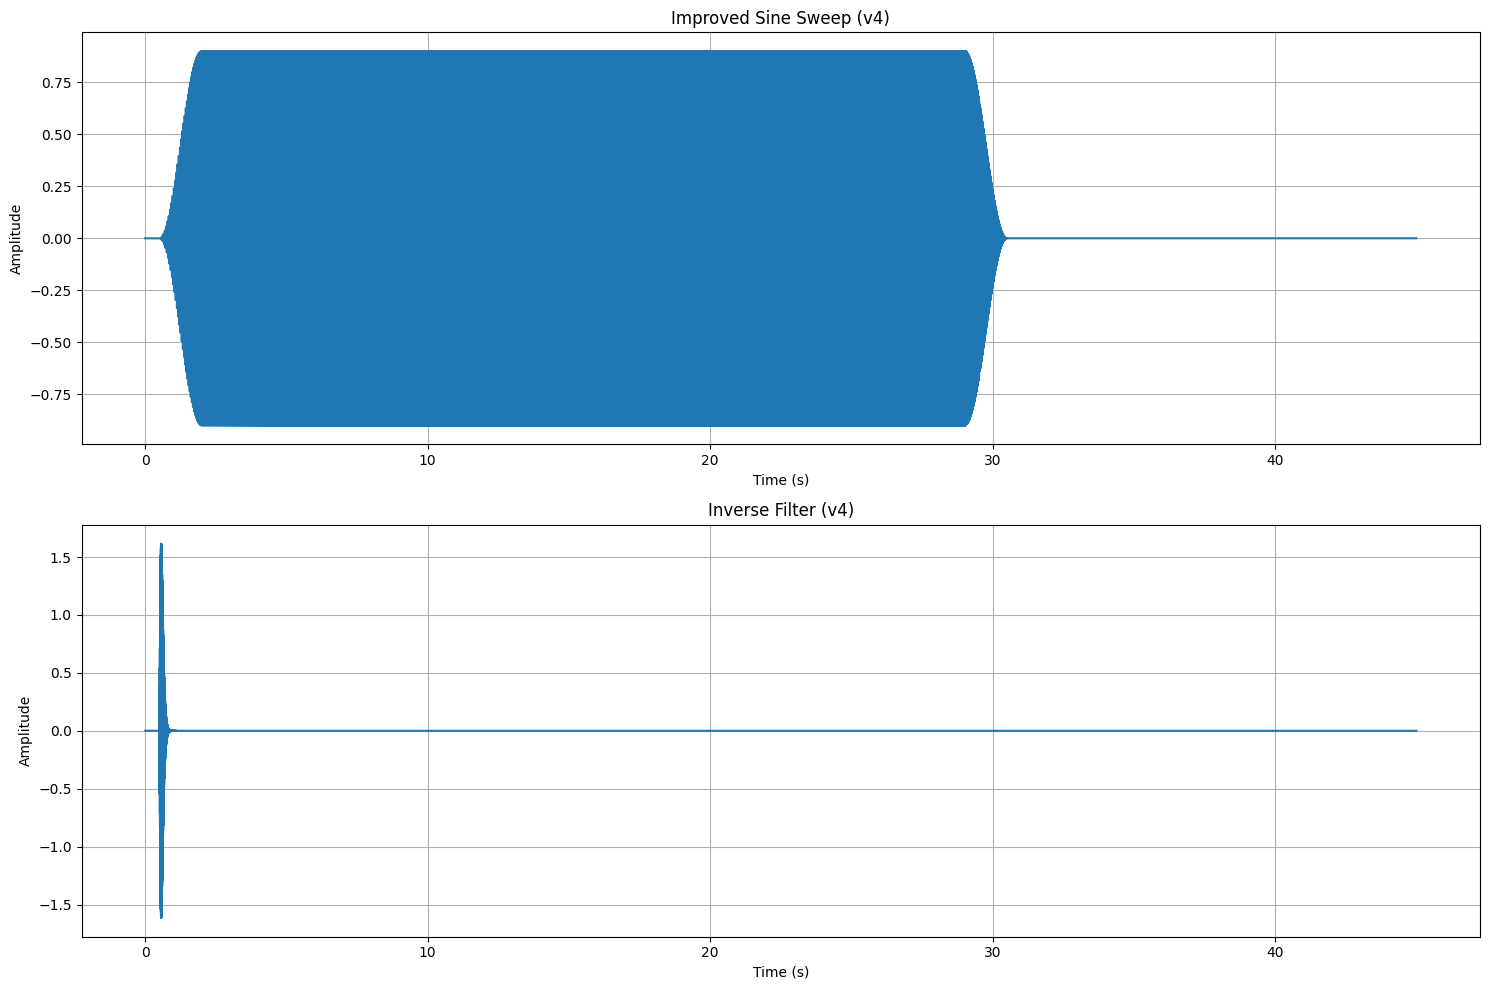

Sweep duration: 45.00 seconds
Sweep max amplitude: 0.9000
Inverse filter duration: 45.00 seconds
Inverse filter max amplitude: 1.6166


In [3]:
# Generate new sweep and inverse filter
fs = 48000
sweep, inverse_filter = generate_improved_sine_sweep_v4(fs=fs, duration=45, sweep_duration=30)

# Save the new sweep
wavfile.write('improved_sine_sweep_v4.wav', fs, np.int16(sweep * 32767))

# Save the new inverse filter
wavfile.write('improved_inverse_filter_v4.wav', fs, np.int16(inverse_filter * 32767))

print("Improved sine sweep and inverse filter (v4) generated and saved.")

# Plot the sweep and inverse filter
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(sweep)) / fs, sweep)
plt.title('Improved Sine Sweep (v4)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(inverse_filter)) / fs, inverse_filter)
plt.title('Inverse Filter (v4)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"Sweep duration: {len(sweep)/fs:.2f} seconds")
print(f"Sweep max amplitude: {np.max(np.abs(sweep)):.4f}")
print(f"Inverse filter duration: {len(inverse_filter)/fs:.2f} seconds")
print(f"Inverse filter max amplitude: {np.max(np.abs(inverse_filter)):.4f}")

In [8]:
# Define the relative path
relative_path = os.path.join('..', '..', 'Atiyeh-RIR-evaluation-Matlab', 'sounds', 'KT_GDP')

# Load the recorded sweep
recorded_sweep_path = 'KT_Unity_bf.wav'
fs_rec, recorded_sweep = wavfile.read(recorded_sweep_path)
recorded_sweep = np.array(recorded_sweep)
print('fs_recorded', fs_rec)

# Truncate one channel for deconvolution
rec_ch1 = recorded_sweep[:, 1] if recorded_sweep.ndim > 1 else recorded_sweep
print('record', recorded_sweep.shape)
print('record_ch1', rec_ch1.shape)

# Convert to float
rec_ch1 = rec_ch1.astype(float) / 32768.0

# Load the inverse filter
inverse_filter_path = 'improved_inverse_filter_v2.wav'
_, inverse_filter = wavfile.read(inverse_filter_path)
inverse_filter = inverse_filter.astype(float) / 32768.0

# Align signals
rec_ch1, inverse_filter = align_signals(rec_ch1, inverse_filter, fs_rec)

# Perform deconvolution
rir = fftconvolve(rec_ch1, inverse_filter, mode='full')

# Find the peak and shift
peak_index = np.argmax(np.abs(rir))
rir = np.roll(rir, -peak_index)[:fs_rec * 10]  # Keep 10 seconds after the peak

# Apply a gentle fade out to reduce artifacts
fade_length = int(0.1 * fs_rec)  # 100 ms fade
fade_out = np.linspace(1, 0, fade_length)**2
rir[-fade_length:] *= fade_out

# Normalize
rir /= np.max(np.abs(rir))

# Save the RIR
output_path = os.path.join(relative_path, 'RIR_KT_Unity_bf.wav')
wavfile.write(output_path, fs_rec, np.int16(rir * 32767))

print(f"Room Impulse Response generated and saved as {output_path}")

fs_recorded 48000
record (1200000, 2)
record_ch1 (1200000,)
Room Impulse Response generated and saved as ..\..\Atiyeh-RIR-evaluation-Matlab\sounds\KT_GDP\RIR_KT_Unity_bf.wav


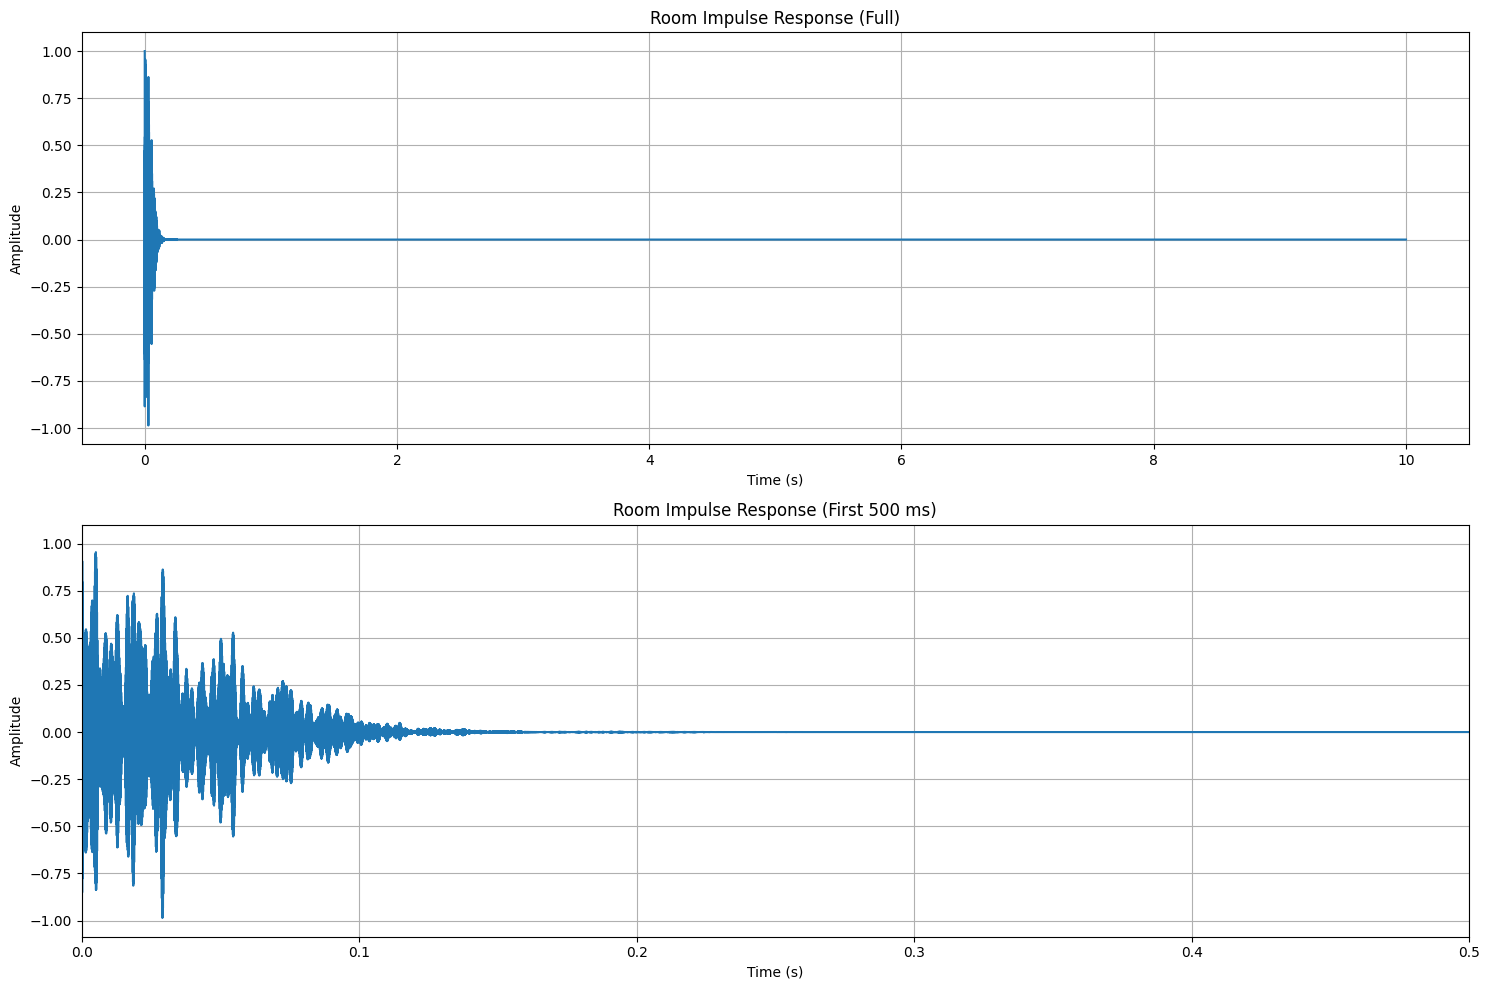

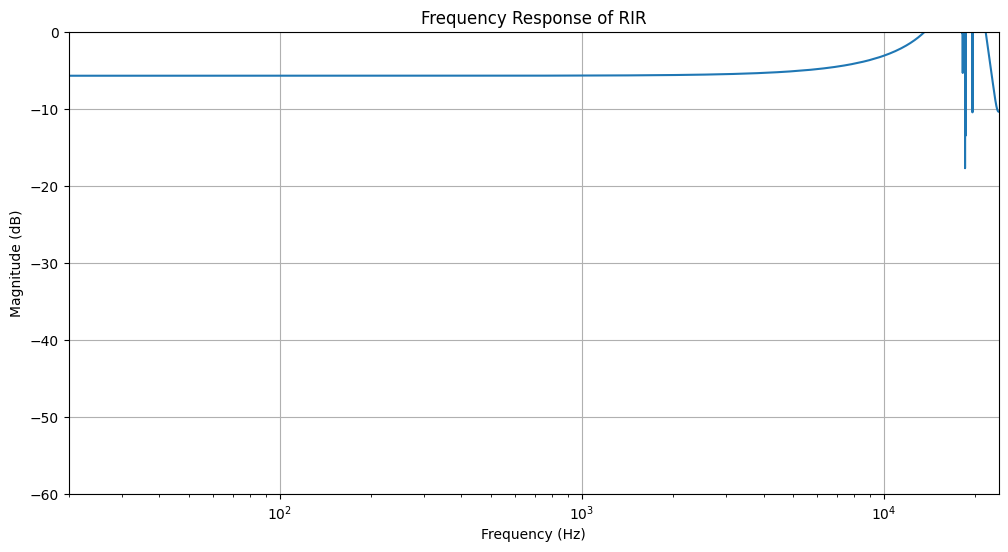

RIR statistics:
Length: 480000 samples
Duration: 10.00 seconds
Max amplitude: 1.0000
RMS value: 0.0233


In [9]:
# Plot the result
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.arange(len(rir)) / fs_rec, rir)
plt.title('Room Impulse Response (Full)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(np.arange(len(rir)) / fs_rec, rir)
plt.title('Room Impulse Response (First 500 ms)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.xlim(0, 0.5)
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the frequency response
freq_response = np.abs(np.fft.rfft(rir))
freq_axis = np.fft.rfftfreq(len(rir), d=1/fs_rec)

plt.figure(figsize=(12, 6))
plt.semilogx(freq_axis, 20 * np.log10(freq_response))
plt.title('Frequency Response of RIR')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(20, fs_rec/2)
plt.ylim(-60, 0)
plt.grid(True)
plt.show()

print("RIR statistics:")
print(f"Length: {len(rir)} samples")
print(f"Duration: {len(rir)/fs_rec:.2f} seconds")
print(f"Max amplitude: {np.max(np.abs(rir)):.4f}")
print(f"RMS value: {np.sqrt(np.mean(rir**2)):.4f}")